In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from vae import VAE
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Importing Data

In [3]:
df = pd.read_csv("../Data/data1.csv").drop(columns='Unnamed: 0')

In [4]:
X_data = df.drop(columns='income')

X_train, X_test = train_test_split(X_data, test_size=0.3, random_state=7)

In [5]:
X1_train = torch.from_numpy(X_train[X_train['gender_Female'] == 1.0].values).to(torch.float32)
X1_test = torch.from_numpy(X_test[X_test['gender_Female'] == 1.0].values).to(torch.float32)
X1_train.to(device)
X1_test.to(device)

X0_train = torch.from_numpy(X_train[X_train['gender_Female'] == 0.0].values).to(torch.float32)
X0_test = torch.from_numpy(X_test[X_test['gender_Female'] == 0.0].values).to(torch.float32)
X0_train.to(device)
X0_test.to(device) 

tensor([[-1.6302, -1.2216, -0.1467,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6467,  0.3453, -0.1467,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4125, -0.4381, -0.1467,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.0934,  1.1288, -0.1467,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.5473, -2.0050, -0.1467,  ...,  0.0000,  0.0000,  0.0000],
        [-1.4789, -0.0464, -0.1467,  ...,  0.0000,  0.0000,  0.0000]])

# Dataset and Dataloader

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self,idx):
        return self.data[idx]

In [7]:
X1_trainset = CustomDataset(X1_train)
X1_testset = CustomDataset(X1_test)

X1_trainloader = DataLoader(X1_trainset, batch_size=128, shuffle=True)
X1_testloader = DataLoader(X1_testset, batch_size=128)

In [8]:
X0_trainset = CustomDataset(X0_train)
X0_testset = CustomDataset(X0_test)

X0_trainloader = DataLoader(X0_trainset, batch_size=128, shuffle=True)
X0_testloader = DataLoader(X0_testset, batch_size=128)

# Loss function and train-test loops

In [47]:
def loss_function(x, x_hat, mean, log_var, cat_index):
    mse_loss = F.mse_loss(x_hat, x, reduction='mean')
    reconstruction_loss = mse_loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
    return reconstruction_loss + kl_divergence

In [18]:
def train(model, optimizer, train_loader):
    model.train()
    train_loss = 0
    for x in train_loader:
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var, 4)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(train_loader.dataset)

In [27]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x in test_loader:
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var, 4)
            test_loss += loss.item()
    return test_loss / len(test_loader.dataset)

# Initializing the VAE(s)

In [71]:
vae0 = VAE(102, 64, 16).to(device)
optimizer0 = torch.optim.AdamW(vae0.parameters(), lr=0.001)

# Training the VAEs

In [72]:
plotter = {
    't_loss': [],
    'v_loss': []
}

In [73]:
for epoch in range(1,30):
    train_loss = train(vae0, optimizer0, X0_trainloader)
    test_loss = test(vae0, X0_testloader)

    plotter['t_loss'].append(train_loss)
    plotter['v_loss'].append(test_loss)
    print(np.round(train_loss, 5), np.round(test_loss, 5))

0.00489 0.00094
0.00084 0.00078
0.00075 0.00074
0.00072 0.00072
0.00071 0.00072
0.0007 0.00071
0.0007 0.00071
0.0007 0.0007
0.0007 0.0007
0.0007 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007
0.00069 0.0007


In [74]:
import matplotlib.pyplot as plt

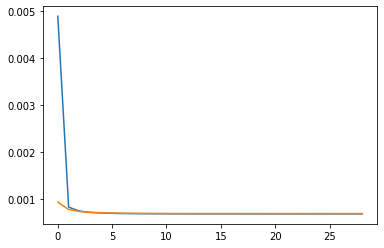

In [75]:
plt.plot(plotter['t_loss'])
plt.plot(plotter['v_loss'])